# PDE-FIND for the Nonlinear Schrodinger Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on the Nonlinear Schrodinger Equation.

\begin{align*}
i u_t &+ \frac{1}{2} u_{xx} + |u|^2 u = 0\\
u_t &= 0.5 i u_{xx} + i |u|^2u
\end{align*}

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = sio.loadmat('./canonicalPDEs/nls.mat')
u = data['usol']
x = data['x'][0]
t = data['t'][:,0]
dt = t[1]-t[0]
dx = x[2]-x[1]

n = len(x)
m = len(t)

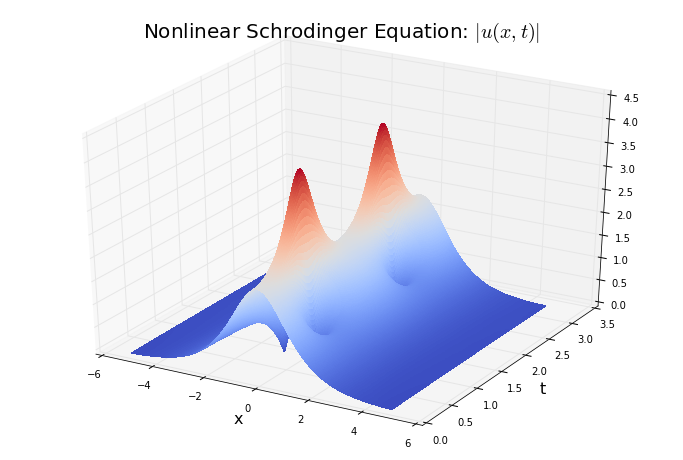

In [3]:
X, T = np.meshgrid(x, t)
fig = figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, abs(u), rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title(r'Nonlinear Schrodinger Equation: $|u(x,t)|$', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

## Construct $\Theta (U)$ and compute $U_t$

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [4]:
ut = np.zeros((m,n), dtype=np.complex64)
ux = np.zeros((m,n), dtype=np.complex64)
uxx = np.zeros((m,n), dtype=np.complex64)
uxxx = np.zeros((m,n), dtype=np.complex64)

for i in range(n):
    ut[:,i] = FiniteDiff(u[:,i], dt, 1)
for i in range(m):
    ux[i,:] = FiniteDiff(u[i,:], dx, 1)
    uxx[i,:] = FiniteDiff(u[i,:], dx, 2)
    uxxx[i,:] = FiniteDiff(u[i,:], dx, 3)
    
ut = np.reshape(ut, (n*m,1), order='F')
ux = np.reshape(ux, (n*m,1), order='F')
uxx = np.reshape(uxx, (n*m,1), order='F')
uxxx = np.reshape(uxxx, (n*m,1), order='F')
X_ders = np.hstack([np.ones((n*m,1)),ux,uxx,uxxx])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'), np.reshape(abs(u), (n*m,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

X, rhs_des = build_Theta(X_data, X_ders, derivatives_description, 3, data_description = ['u','|u|'])

In [5]:
rhs_des

['',
 'u_{x}',
 'u_{xx}',
 'u_{xxx}',
 '|u|',
 'u|u|^2',
 'u^3',
 '|u|^3',
 'u|u|',
 'u^2',
 'u^2|u|',
 'u',
 '|u|^2',
 '|u|u_{x}',
 'u|u|^2u_{x}',
 'u^3u_{x}',
 '|u|^3u_{x}',
 'u|u|u_{x}',
 'u^2u_{x}',
 'u^2|u|u_{x}',
 'uu_{x}',
 '|u|^2u_{x}',
 '|u|u_{xx}',
 'u|u|^2u_{xx}',
 'u^3u_{xx}',
 '|u|^3u_{xx}',
 'u|u|u_{xx}',
 'u^2u_{xx}',
 'u^2|u|u_{xx}',
 'uu_{xx}',
 '|u|^2u_{xx}',
 '|u|u_{xxx}',
 'u|u|^2u_{xxx}',
 'u^3u_{xxx}',
 '|u|^3u_{xxx}',
 'u|u|u_{xxx}',
 'u^2u_{xxx}',
 'u^2|u|u_{xxx}',
 'uu_{xxx}',
 '|u|^2u_{xxx}']

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [6]:
# Solve with STRidge
w = TrainSTRidge(X,ut,10**-5,500)
print "PDE derived using STRidge"
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-0.000000 +0.500310i)u_{xx}
    + (-0.000000 +0.999674i)u|u|^2
   


In [7]:
err = abs(np.array([(1j*(0.5-0.500310))*100/0.5, (1j*(1-0.999674))*100]))
print mean(err)
print std(err)

0.0473
0.0147


## Same as above but with added noise

In [8]:
# Now try to do it with noise.
numpy.random.seed(0)
un = u + 0.01/np.sqrt(2)*std(real(u))*np.random.randn(u.shape[0],u.shape[1]) + 0.01/np.sqrt(2)*1j*std(imag(u))*np.random.randn(u.shape[0],u.shape[1])

In [9]:
width_x = 10
width_t = 10
deg = 4

m,n=u.shape

m2 = m-2*width_t
n2 = n-2*width_x

utn = np.zeros((m2,n2), dtype=np.complex64)
uxn = np.zeros((m2,n2), dtype=np.complex64)
uxxn = np.zeros((m2,n2), dtype=np.complex64)
uxxxn = np.zeros((m2,n2), dtype=np.complex64)

for i in range(n2):
    utn[:,i] = PolyDiff(real(un[:,i+width_x]), dt*np.arange(m), deg = deg, width = width_t)[:,0]
    utn[:,i] = utn[:,i]+1j*PolyDiff(imag(un[:,i+width_x]), dt*np.arange(m), deg = deg, width = width_t)[:,0]

for i in range(m2):
    x_derivatives = PolyDiff(real(un[i+width_t,:]), dx*np.arange(n), deg = deg, diff = 3, width = width_x)
    x_derivatives = x_derivatives+1j*PolyDiff(imag(un[i+width_t,:]), dx*np.arange(n), deg = deg, diff = 3, width = width_x)
    uxn[i,:] = x_derivatives[:,0]
    uxxn[i,:] = x_derivatives[:,1]
    uxxxn[i,:] = x_derivatives[:,2]

utn = np.reshape(utn, (n2*m2,1), order='F')
uxn = np.reshape(uxn, (n2*m2,1), order='F')
uxxn = np.reshape(uxxn, (n2*m2,1), order='F')
uxxxn = np.reshape(uxxxn, (n2*m2,1), order='F')
Xn_ders = np.hstack([np.ones((n2*m2,1)),uxn,uxxn,uxxxn])
Xn_data = np.hstack([np.reshape(un[width_t:m-width_t,width_x:n-width_x], (n2*m2,1), order='F'),
                     np.reshape(abs(un[width_t:m-width_t,width_x:n-width_x]), (n2*m2,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

Xn, rhs_des = build_Theta(Xn_data, Xn_ders, derivatives_description, 3, data_description = ['u','|u|'])

In [10]:
# Solve with STRidge
lam = 10**-5
d_tol = 500

wn = TrainSTRidge(Xn,utn,lam,d_tol)
print "PDE derived using STRidge"
print_pde(wn, rhs_des)

PDE derived using STRidge
u_t = (0.000134 +0.478631i)u_{xx}
    + (0.000078 +0.981648i)u|u|^2
   


In [11]:
err = abs(np.array([(1j*(0.5-0.478631)+0.000134)*100/0.5, (1j*(1-0.981648)+0.000078)*100]))
print mean(err)
print std(err)

3.05455030161
1.21933372583
